# WBC Classification using Deep Learning Techniques


### Importing Libraries

In [ ]:
# Check GPU availability:
import tensorflow as tf

# Check if TensorFlow is built with GPU support
print("Built with CUDA:", tf.test.is_built_with_cuda())

# List available devices
print("Available devices:", tf.config.list_physical_devices('GPU'))

# Check if TensorFlow can access a GPU
print("Is GPU available:", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Built with CUDA: True
Available devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is GPU available: True


In [ ]:
# Verify CUDA and cuDNN installation:
!nvcc --version
!cat /usr/local/cuda/version.txt

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
cat: /usr/local/cuda/version.txt: No such file or directory
TensorFlow version: 2.15.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# scikit learn essentials
!pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# Tensorflow essentials
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization, Input, concatenate, Reshape, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import tensorflow.keras.backend as K

In [ ]:
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
%matplotlib inline
from tqdm import tqdm

In [ ]:
# Unzipping the dataset
!unzip dataset.zip -d dataset

unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.


In [ ]:
!pip install kaggle

In [ ]:
# Configuring the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# API to fetch the dataset from kaggle
!kaggle datasets download -d paultimothymooney/blood-cells

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/blood-cells
License(s): other
blood-cells.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Extracting the compressed dataset
from zipfile import ZipFile
dataset = '/content/blood-cells.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [ ]:
"""
- tree_path points to the directory where annotation files
  (e.g., XML files) are stored.

- image_path points to the directory where the actual image
  files (e.g., JPEG images) are located.
"""
class1 = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
class2 = {0:'Mononuclear',1:'Polynuclear'}
tree_path = '../content/dataset-master/dataset-master/Annotations'
image_path = '../content/dataset-master/dataset-master/JPEGImages'

In [ ]:
# Sample image Generation
image = cv2.imread(image_path+'/BloodImage_00002.jpg')
tree = ET.parse(tree_path+'/BloodImage_00002.xml')
try:
    image.shape
    print("Checked for shape. Shape is {}".format(image.shape))
except AttributeError:
    print("Error: Invalid shape.")

Checked for shape. Shape is (480, 640, 3)


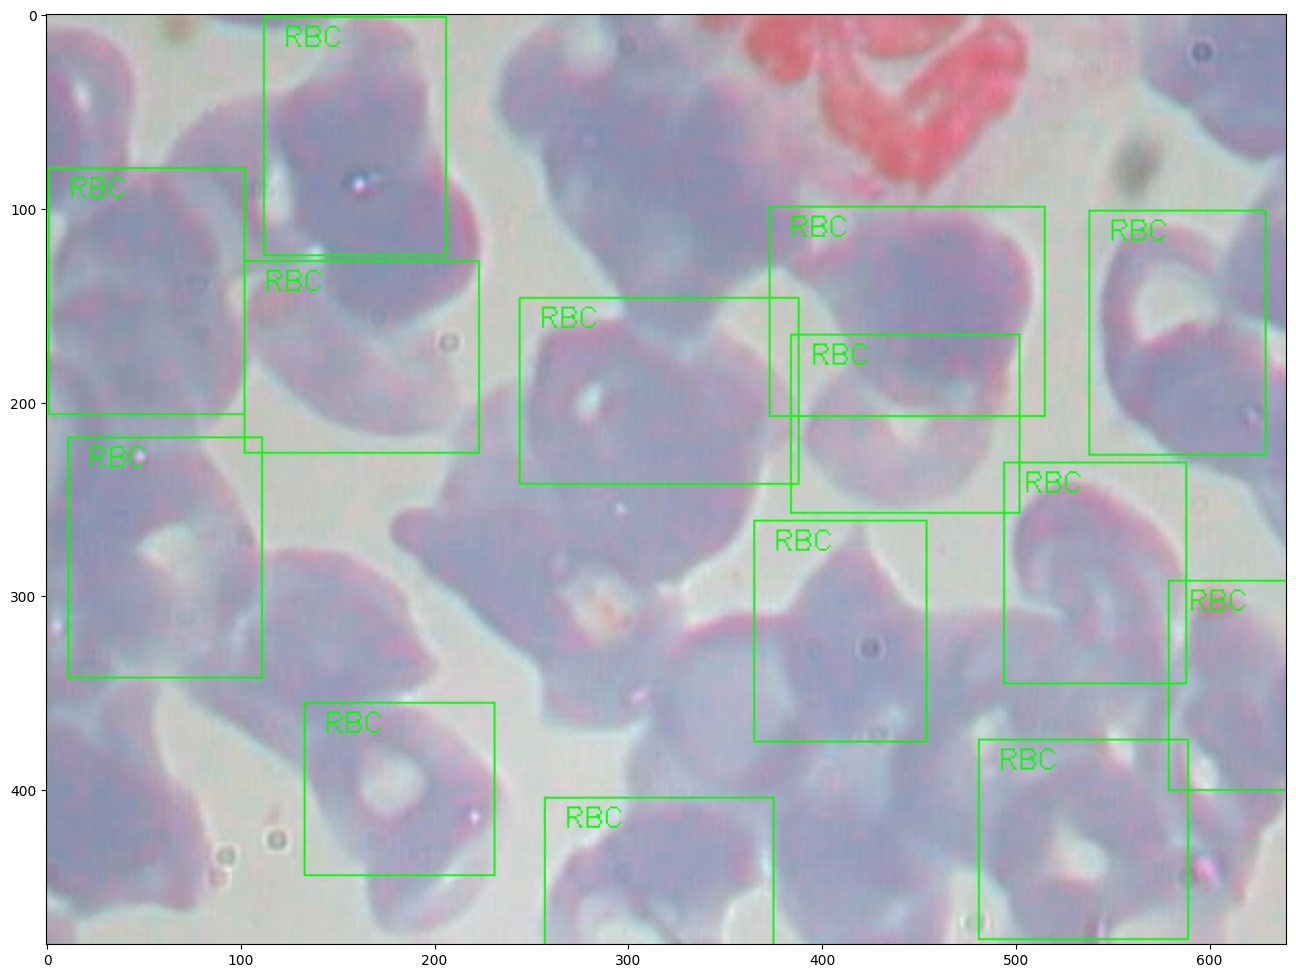

In [ ]:
"""
This code is iterating over elements in an XML tree (presumably containing annotations for object detection) and extracting information about
objects and their bounding boxes. It then uses OpenCV (cv2) to draw rectangles and labels on an image based on this information.

Let's break down the code:

The loop for elem in tree.iter(): iterates over each element in the XML tree.

Inside the loop, it checks if the tag of the element contains the substring 'object' or 'part' using if 'object' in elem.tag or 'part' in
elem.tag:.
If the condition is true, it iterates over the child elements of the current element using for attr in list(elem):.
Within this loop, it checks for specific tags such as 'name' and 'bndbox' to extract information about the object's name and
its bounding box dimensions.
For each bounding box, it extracts the coordinates (xmin, ymin, xmax, ymax) and converts them to integers.

Based on the object's name (presumably representing different classes), it draws rectangles and labels using OpenCV's cv2.rectangle() and
cv2.putText() functions.

The colors of the rectangles and labels are chosen based on the object's name prefix ('R', 'W', 'P').
Finally, it plots the annotated image using Matplotlib.
"""

for elem in tree.iter():
  if 'object' in elem.tag or 'part' in elem.tag:
    for attr in list(elem):
      if 'name' in attr.tag:
        name = attr.text
      if 'bndbox' in attr.tag:
        for dim in list(attr):
          if 'xmin' in dim.tag:
            xmin = int(round(float(dim.text)))
          if 'ymin' in dim.tag:
            ymin = int(round(float(dim.text)))
          if 'xmax' in dim.tag:
            xmax = int(round(float(dim.text)))
          if 'ymax' in dim.tag:
            ymax = int(round(float(dim.text)))
        if name[0] == "R":
          cv2.rectangle(image, (xmin, ymin),
                        (xmax, ymax), (0,255,0), 1)
          cv2.putText(image, name, (xmin + 10, ymin + 15),
                      cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 255, 0), 1)
        if name[0] == "W":
          cv2.rectangle(image, (xmin, ymin),
                        (xmax, ymax), (0, 0, 255), 1)
          cv2.putText(image, name, (xmin + 10, ymin + 15),
                      cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 255), 1)
        if name[0] == "P":
          cv2.rectangle(image, (xmin, ymin),
                        (xmax, ymax), (255, 0, 0), 1)
          cv2.putText(image, name, (xmin + 10, ymin + 15),
                      cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255, 0, 0), 1)
plt.figure(figsize=(16,16))
plt.imshow(image)
plt.show()

In [ ]:
df = pd.read_csv('../content/dataset-master/dataset-master/labels.csv')
df = df.drop(columns=['Unnamed: 0']).dropna()
df

,Image,Category
0,0,NEUTROPHIL
1,1,NEUTROPHIL
2,2,NEUTROPHIL
3,3,NEUTROPHIL
4,4,NEUTROPHIL
...,...,...
405,405,NEUTROPHIL
407,407,NEUTROPHIL
408,408,NEUTROPHIL
409,409,NEUTROPHIL


In [ ]:
"""
1.
df1["Category"].str.contains(",", na=False): This part checks each entry in
the "Category" column of the DataFrame df1 to see if it contains a comma.
It returns a boolean Series where True indicates the presence of a comma.

2.
~: This operator negates the boolean values in the Series.
So, ~True becomes False and vice versa.

3.
df1[~df1["Category"].str.contains(",", na=False)]: This part filters the DataFrame
df1 to select rows where the "Category" column does not contain a comma.

4.
['Category']: Finally, it selects only the "Category" column from the filtered DataFrame.
So, y3 will contain the values from the "Category" column of df1 where the "Category" does not contain a comma.
"""

y3 = df[~df['Category'].str.contains(",", na=False)]['Category']
y3

0      NEUTROPHIL
1      NEUTROPHIL
2      NEUTROPHIL
3      NEUTROPHIL
4      NEUTROPHIL
          ...    
405    NEUTROPHIL
407    NEUTROPHIL
408    NEUTROPHIL
409    NEUTROPHIL
410    EOSINOPHIL
Name: Category, Length: 352, dtype: object

In [ ]:
# Label encoding, transforming and visualizing the number of different types of cells

encoder = LabelEncoder()
encoder.fit(y3)
encoded_y = encoder.transform(y3)
counts = np.bincount(encoded_y)
print(counts)

[  3  88  33  21 207]


<ipython-input-18-b7e9d2d0da8f>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(('', 'Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))


Text(0, 0.5, 'Number of Cells')

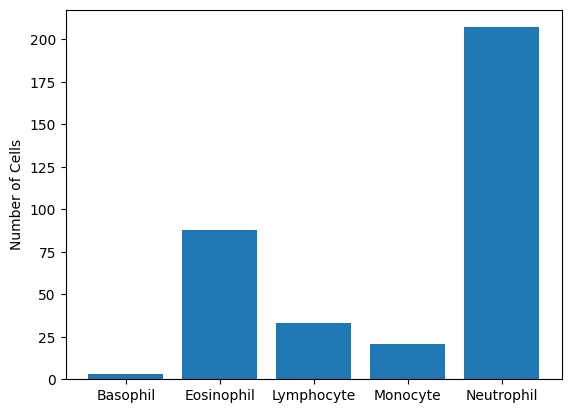

In [ ]:
# Visualizing

fig, ax = plt.subplots()
plt.bar(list(range(5)), counts)
ax.set_xticklabels(('', 'Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))
ax.set_ylabel('Number of Cells')

In [ ]:
def get_data(folder):
  # Load the data and labels from the given folder
  X = []
  y = []
  z = []
  for wbc_type in os.listdir(folder):
    print(wbc_type)
    if not wbc_type.startswith('.'):
      if wbc_type in ['NEUTROPHIL']:
        label1 = 1  # the type
        label2 = 1  # the class (the two types of wbcs)
      elif wbc_type in ['EOSINOPHIL']:
        label1 = 2
        label2 = 1
      elif wbc_type in ['MONOCYTE']:
        label1 = 3
        label2 = 0
      elif wbc_type in ['LYMPHOCYTE']:
        label1 = 4
        label2 = 0
      else:
        label1 = 5
        label2 = 0
      for image_filename in tqdm(os.listdir(folder + wbc_type)):
        img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
        if img_file is not None:
          img_file = cv2.resize(img_file, dsize=(80, 60), interpolation = cv2.INTER_CUBIC)
          img_arr = np.asarray(img_file)
          X.append(img_arr)
          y.append(label1)
          z.append(label2)
  X = np.asarray(X)
  y = np.asarray(y)
  z = np.asarray(z)
  return X, y, z

X_train, y_train, z_train = get_data('../content/dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('../content/dataset2-master/dataset2-master/images/TEST/')

LYMPHOCYTE


100%|██████████| 2483/2483 [00:03<00:00, 709.87it/s]


EOSINOPHIL


100%|██████████| 2497/2497 [00:05<00:00, 457.85it/s]


NEUTROPHIL


100%|██████████| 2499/2499 [00:08<00:00, 300.80it/s]


MONOCYTE


100%|██████████| 2478/2478 [00:06<00:00, 412.86it/s]


LYMPHOCYTE


100%|██████████| 620/620 [00:01<00:00, 381.25it/s]


EOSINOPHIL


100%|██████████| 623/623 [00:02<00:00, 235.71it/s]


NEUTROPHIL


100%|██████████| 624/624 [00:01<00:00, 334.71it/s]


MONOCYTE


100%|██████████| 620/620 [00:01<00:00, 399.20it/s]


In [ ]:
# Encode labels

from tensorflow.keras.utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
print(class1)
print(class2)

{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}
{0: 'Mononuclear', 1: 'Polynuclear'}


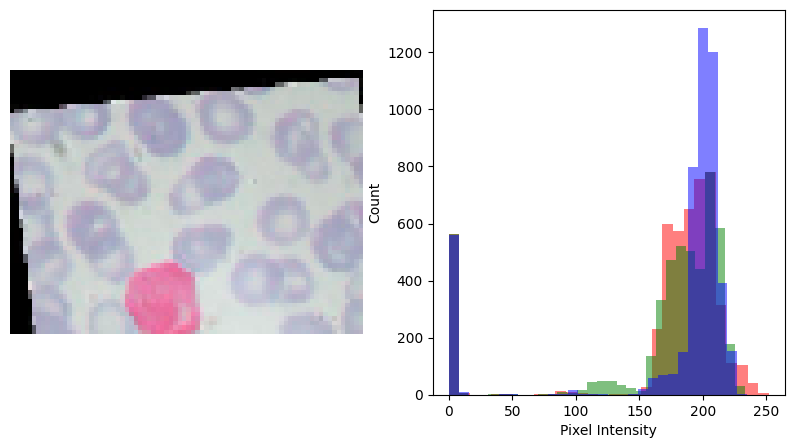

In [ ]:
def plotHistogram(a):
  # Plot histogram of RGB Pixel Intensities
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.imshow(a)
  plt.axis('off')

  histo = plt.subplot(1,2,2)
  histo.set_ylabel('Count')
  histo.set_xlabel('Pixel Intensity')
  n_bins = 30
  plt.hist(a[:,:,0].flatten(), bins = n_bins, lw = 0, color='r', alpha=0.5);
  plt.hist(a[:,:,1].flatten(), bins = n_bins, lw = 0, color='g', alpha=0.5);
  plt.hist(a[:,:,2].flatten(), bins = n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

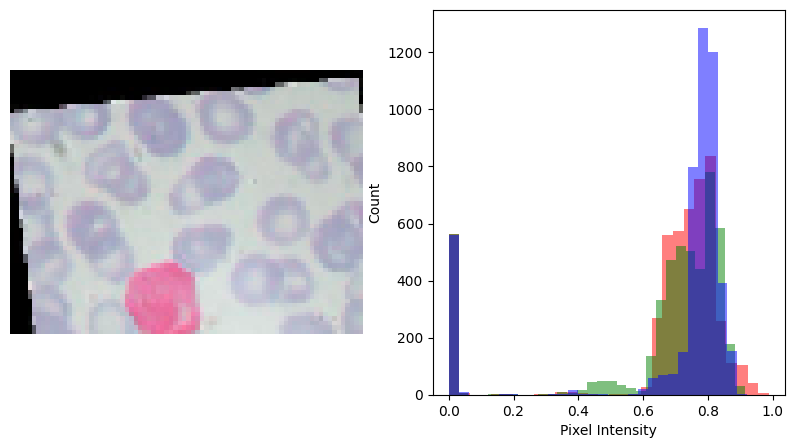

In [ ]:
# Normalization

X_train = np.array(X_train)
X_train = X_train/255.0

X_test = np.array(X_test)
X_test = X_test/255.0

plotHistogram(X_train[1])

In [ ]:
# RGB to grayscale
def rgb_to_grayscale(input):
   return K.mean(input, axis=3)
def rgb_to_grayscale_output_shape(input_shape):
  return input_shape[:-1]

In [ ]:
# Helper Functions
# Callback that saves metrics after each epoch
class MetricsCheckpoint(Callback):
  def __init__(self, savepath):
    super(MetricsCheckpoint, self).__init__()
    self.savepath = savepath
    self.history = {}
  def on_epoch_end(self, epoch, logs=None):
    for k, v in logs.items():
      self.history.setdefault(k, []).append(v)
    np.save(self.savepath, self.history)

In [ ]:
# Plotting a learning curve
def plotKeraslearningCurve():
  plt.figure(figsize=(10, 5))
  metrics = np.load('logs.npy', allow_pickle=True)[()]
  filt = ['acc']
  for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
    l = np.array(metrics[k])
    plt.plot(l, c= 'r' if 'val' not in k else 'b',label='val' if 'val' in k else 'train')
    x = np.argmin(l) if 'loss' in k else np.argmax(l)
    y = l[x]
    plt.scatter(x, y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
    plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color='r' if 'val' not in k else 'b')
  plt.legend(loc=4)
  plt.axis([0, None, None, None]);
  plt.grid()
  plt.xlabel('Number of epochs')
  plt.ylabel('Accuracy')

In [ ]:
# Plotting a confusion matrix
# This function prints and plots the confusion matrix.
# Normalization can be applied by setting `normalize=True`.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
  plt.figure(figsize=(5, 5))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [ ]:
def plot_learning_curve(history):
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,1)
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig('./accuracy_curve.png')

  # summarize history for loss
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig('/loss_curve.png')

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, concatenate, Lambda, LSTM, BatchNormalization, Reshape, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
def runKerasCNNAugment(a, b, c, d, e, epochs, classes):

    batch_size = 128
    num_classes = len(b[0])
    img_rows, img_cols = 60, 80
    input_shape = (img_rows, img_cols, 3)
    input_tensor = Input(shape=input_shape)

    # Creating CNN
    modelcnn = Sequential()
    modelcnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, strides=e))
    modelcnn.add(BatchNormalization())
    modelcnn.add(Conv2D(64, (3, 3), activation='relu'))
    modelcnn.add(BatchNormalization())
    modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
    modelcnn.add(Dropout(0.25))

    modelcnn.add(Conv2D(128, (3, 3), activation='relu'))
    modelcnn.add(BatchNormalization())
    modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
    modelcnn.add(Dropout(0.25))

    modelcnn.add(Flatten())
    cnn_output = modelcnn(input_tensor)

    # Creating RNN
    def rgb_to_grayscale(x):
        return tf.reduce_mean(x, axis=-1, keepdims=True)

    def rgb_to_grayscale_output_shape(input_shape):
        return input_shape[:-1] + (1,)

    modelrnn = Lambda(rgb_to_grayscale, output_shape=rgb_to_grayscale_output_shape)(input_tensor)
    modelrnn = Reshape((img_rows * img_cols, 1))(modelrnn)  # Reshaping for LSTM
    modelrnn = LSTM(128, return_sequences=True, dropout=0.0, recurrent_dropout=0.0, activation='tanh', recurrent_activation='sigmoid', use_bias=True, unit_forget_bias=True)(modelrnn)
    rnn_output = LSTM(128, dropout=0.0, recurrent_dropout=0.0, activation='tanh', recurrent_activation='sigmoid', use_bias=True, unit_forget_bias=True)(modelrnn)

    # Merging both cnn bottleneck and rnn's output via concatenation
    merge_layer = concatenate([cnn_output, rnn_output])
    last_process = Dense(256, activation='relu')(merge_layer)
    last_process = Dropout(0.5)(last_process)
    output_tensor = Dense(num_classes, activation='softmax')(last_process)
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

    # Data Augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zoom_range=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=False
    )

    # Callbacks
    lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

    # Training the model
    history = model.fit(datagen.flow(a, b, batch_size=32),
                        steps_per_epoch=len(a) // 32,
                        epochs=epochs,
                        validation_data=(c, d),
                        callbacks=[lr_reduction, early_stopping, model_checkpoint])

    # Evaluating the model
    score = model.evaluate(c, d, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')

    y_pred = model.predict(c)
    map_characters = classes
    print('\n', classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')

    Y_pred_classes = np.argmax(y_pred, axis=1)
    Y_true = np.argmax(d, axis=1)

    # Plotting learning curve
    def plot_learning_curve(history):
        plt.figure()
        plt.plot(history.history['accuracy'], label='train_accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    plot_learning_curve(history)

    # Confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

    def plot_confusion_matrix(cm, classes):
        plt.figure(figsize=(10, 10))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion matrix')
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in np.ndindex(cm.shape):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()

    plot_confusion_matrix(confusion_mtx, classes=list(classes.values()))


Epoch 1/100
311/311 [==============================] - ETA: 0s - loss: 2.1126 - accuracy: 0.2702
Epoch 1: val_accuracy improved from -inf to 0.08645, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


311/311 [==============================] - 131s 377ms/step - loss: 2.1126 - accuracy: 0.2702 - val_loss: 16.9816 - val_accuracy: 0.0864 - lr: 0.0010
Epoch 2/100
311/311 [==============================] - ETA: 0s - loss: 1.3588 - accuracy: 0.3294
Epoch 2: val_accuracy improved from 0.08645 to 0.43064, saving model to best_model.h5
311/311 [==============================] - 105s 337ms/step - loss: 1.3588 - accuracy: 0.3294 - val_loss: 1.1839 - val_accuracy: 0.4306 - lr: 0.0010
Epoch 3/100
311/311 [==============================] - ETA: 0s - loss: 1.3084 - accuracy: 0.3674
Epoch 3: val_accuracy did not improve from 0.43064
311/311 [==============================] - 103s 332ms/step - loss: 1.3084 - accuracy: 0.3674 - val_loss: 4.7353 - val_accuracy: 0.2509 - lr: 0.0010
Epoch 4/100
311/311 [==============================] - ETA: 0s - loss: 1.2711 - accuracy: 0.3941
Epoch 4: val_accuracy did not improve from 0.43064
311/311 [==============================] - 103s 332ms/step - loss: 1.2711 - 

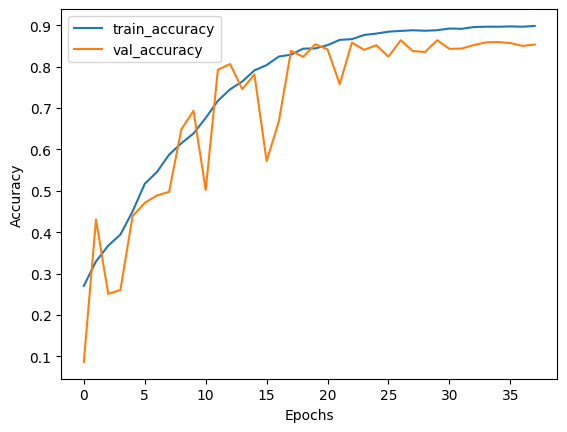

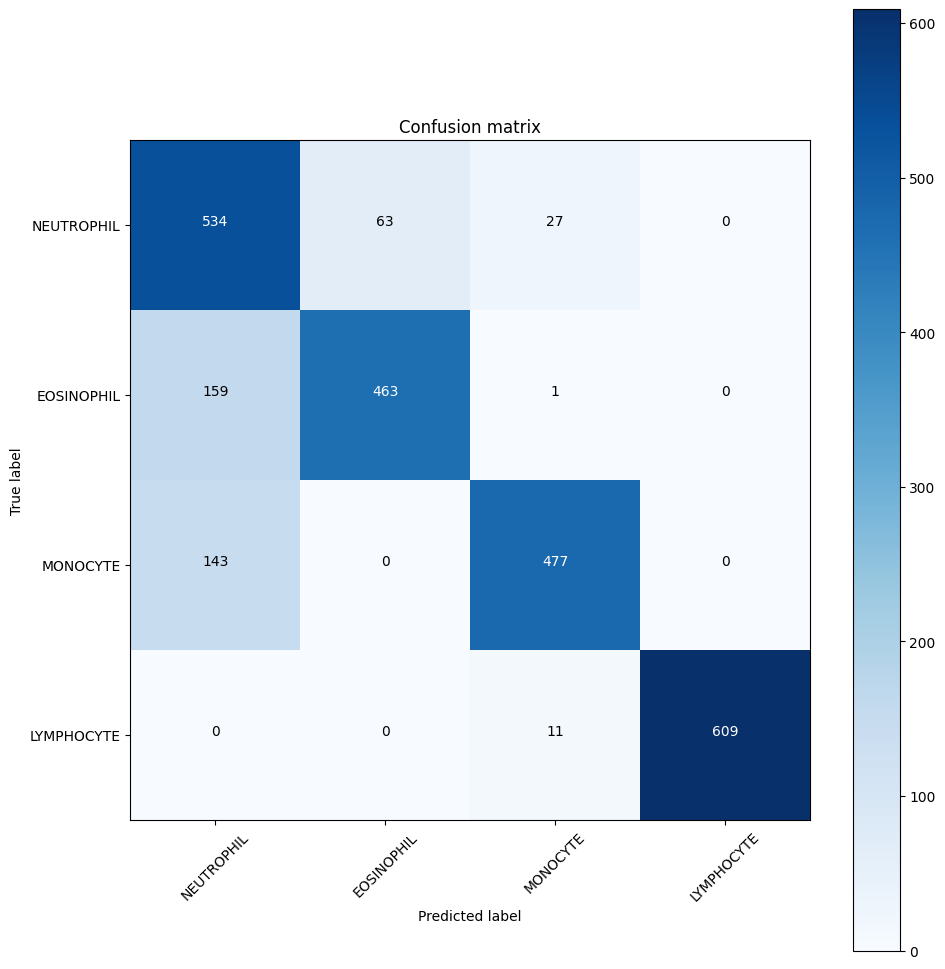

In [ ]:
runKerasCNNAugment(X_train,y_trainHot,X_test,y_testHot,1, 100, class1)

Epoch 1/50
311/311 [==============================] - ETA: 0s - loss: 0.7843 - accuracy: 0.5969
Epoch 1: val_accuracy improved from -inf to 0.49859, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


311/311 [==============================] - 134s 403ms/step - loss: 0.7843 - accuracy: 0.5969 - val_loss: 5.2447 - val_accuracy: 0.4986 - lr: 0.0010
Epoch 2/50
311/311 [==============================] - ETA: 0s - loss: 0.4218 - accuracy: 0.7938
Epoch 2: val_accuracy improved from 0.49859 to 0.67994, saving model to best_model.h5
311/311 [==============================] - 100s 321ms/step - loss: 0.4218 - accuracy: 0.7938 - val_loss: 0.6972 - val_accuracy: 0.6799 - lr: 0.0010
Epoch 3/50
311/311 [==============================] - ETA: 0s - loss: 0.2637 - accuracy: 0.8811
Epoch 3: val_accuracy did not improve from 0.67994
311/311 [==============================] - 101s 323ms/step - loss: 0.2637 - accuracy: 0.8811 - val_loss: 7.6236 - val_accuracy: 0.5123 - lr: 0.0010
Epoch 4/50
311/311 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 0.9086
Epoch 4: val_accuracy did not improve from 0.67994
311/311 [==============================] - 99s 318ms/step - loss: 0.2033 - accur

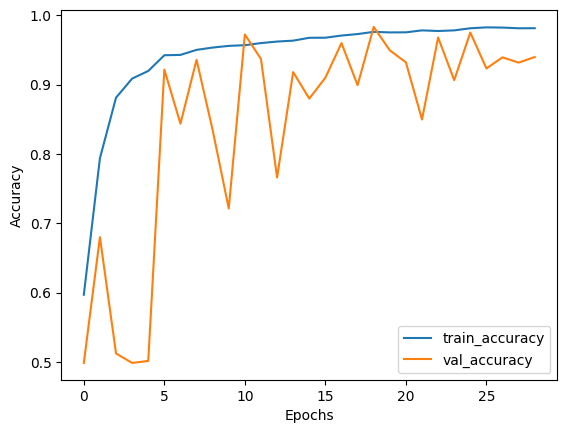

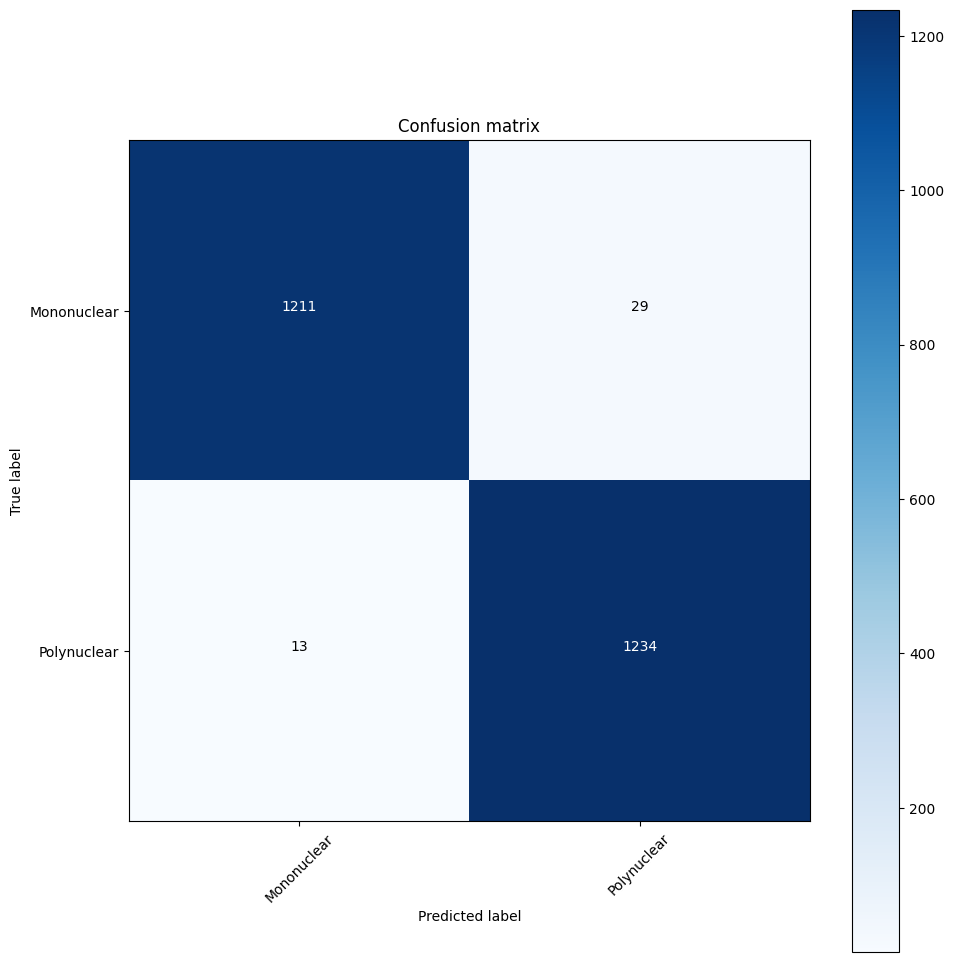

In [ ]:
runKerasCNNAugment(X_train,z_trainHot,X_test,z_testHot,2, 50, class2)